# TP4-G2. Procesamiento de arreglos

**Integrantes:**
- BAUTISTA SCHNEEBERGER
- SANTIAGO EZEQUIEL MANGONE
- SERGIO ANDRES PERALTA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import fft
import IPython.display as ipd
from scipy.io import wavfile
import os
from scipy import linalg
import helper as hp

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
font_name = "Times New Roman"
mpl.rcParams['font.family'] = font_name

----
# 1)

In [3]:
fs, arr = wavfile.read(filename='mtms-arrC1A.wav')

In [4]:
arr = np.swapaxes(arr, 0, 1)
arr.shape

(15, 543489)

## ¿Qué sub-arreglo de sensores es óptimo para este caso?
Resulta de interés poder hacer uso de una configuración de arreglos cuyo sampleo sea lo más parecido a la frecuencia de Nyquist, aunque nunca sobrepasarla. Si no se cumple Nyquist entonces se colarán frecuencias espaciales no deseadas. Por otro lado si se usa una elevada frecuencia espacial de muestreo, se perderá resolución en el espectro. Por lo tanto, para $2\text{kHz}$ tenemos:

$$
\lambda = \frac{v}{F_c} = \frac{340\text{m/s}}{2\text{kHz}} = 17\text{cm}
$$

$$

d \leq \lambda/2 =  8,5\text{cm}
$$
Por lo tanto la configuración que usa $d = 8\text{cm}$ es la mejor.

Si usamos una ventana rectangular, tendremos que $\Delta \phi_{3dB} = \lambda/L = 17\text{cm} / (9\cdot 8\text{cm}) = 13,52\degree$. Por lo tanto, es importante tener en cuenta a la hora de seleccionar el ancho de banda del filtro pasabajos que se usará, que frecuencias temporales distintas actuan *como si* tuviesen otra frecuencia espacial. 
$$
u = \frac{d\sin{(\phi)}}{\lambda} = \frac{d F_c\sin{(\phi)}}{v}
$$
De la fórmula anterior notamos que una $F_c$ desviada de los $2\text{kHz}$ implica en otra frecuencia espacial. Aunque, para el caso en que la onda incide en $0\degree$, es independiente de $F_c$, por lo tanto no es trivial ver el impacto cuantificado de una señal con otra $F_c$. Usamos entonces el criterio que $F_c>>B $, o sea un ancho de banda de $5\%$ para el filtro pasabajos, tendremos poca confusión.
$$
B = 0.05 \cdot 2\text{kHz} = 100\text{Hz}
$$

In [5]:
arr = np.take(arr, [1, 2, 3, 5, 7, 9, 11, 12, 13], axis = 0)

In [6]:
arr.shape

(9, 543489)

## Diseño del filtro pasabajos

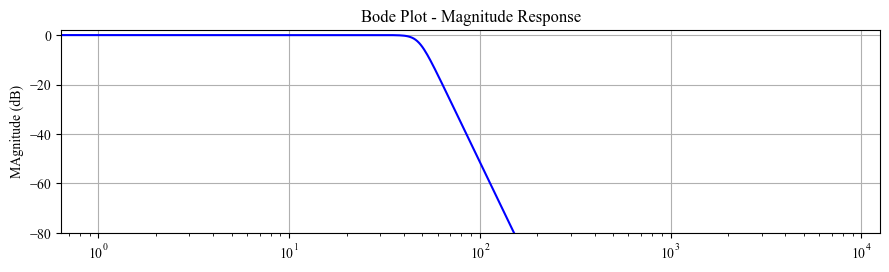

In [7]:
%matplotlib inline
plt.close()
sos_lp = hp.get_lowpass(fs=fs, cutoff_frequency = 50, plot_= True)

----
## Toy Example

Se inyectan dos senos de frecuencia normalizada $u$ de $0,4$ y $-0,2$.

In [8]:
def get_cos(n, f0, fs, i, deg, d = 1, c = 340):
    return np.cos(2*np.pi*(n/fs)*f0 - 2*np.pi * f0 * i * d * np.sin(np.deg2rad(deg)) / c, dtype=np.complex128) 

In [ ]:
M = 9
f0 = 2020
T_window = 500e-3
n = np.arange(0, int(fs*T_window))

C = np.ones(M, dtype=np.complex128) / np.sqrt(M)
s = np.zeros((M, len(n)), dtype=np.complex128)

# Genero los retrasos a los elementos de acuerdo al ángulo de incidencia.
# Se toma d = \lambda/2
window = signal.windows.chebwin(s.shape[0], at=5)
for i in range(s.shape[0]):
    s[i] = get_cos(n, f0, fs, i, np.rad2deg(np.arcsin(2*0.4)), d = 340/(2*f0)) + get_cos(n, f0, fs, i, np.rad2deg(np.arcsin(2*(-0.2))), d = 340/(2*f0)) #+ get_cos(n, f0, fs, i, 10.3)

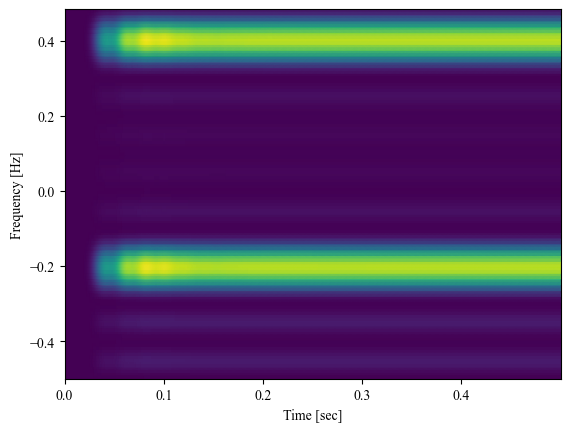

In [36]:
Fc = 2e3
N = s.shape[1] #// 100
y = np.zeros((9, N), dtype=np.complex128)
for i in range(9):
    y[i, :] = signal.sosfilt(sos_lp, np.real(s[i, :N] * np.exp(2j*np.pi*Fc/fs*np.arange(N))) ) \
         + 1j*signal.sosfilt(sos_lp, np.imag(s[i, :N] * np.exp(2j*np.pi*Fc/fs*np.arange(N))) )

Nfft = 64
frqs = fft.fftshift(fft.fftfreq(Nfft, d = 1))
R = np.zeros((Nfft, N))
for j in range(N):
    R[:, j] = np.abs(fft.fftshift(fft.fft(y[:, j], n=Nfft)))**2

t = np.arange(N)/fs

plt.pcolormesh(t, frqs, R, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Observando el espectrogrma, queda entonces demostrado que funciona. Se pueden observar el spectral leakage en distintas frecuencias espaciales producto de los lóbulos de la ventana sinc.

## End Of Toy Example
----

In [ ]:
Fc = 2e3
N = arr.shape[1]
y = np.zeros((9, N), dtype=np.complex128)
window = signal.windows.chebwin(9, at=30)
window = signal.windows.boxcar(9)

for i in range(9):
    y[i, :] = signal.sosfilt(sos_lp, window[i] * np.real(arr[i, :N] * np.exp(2j*np.pi*Fc/fs*np.arange(N))) ) \
         + 1j*signal.sosfilt(sos_lp, window[i] * np.imag(arr[i, :N] * np.exp(2j*np.pi*Fc/fs*np.arange(N))) )

Nfft = 64
frqs = fft.fftshift(fft.fftfreq(Nfft, d = 1))
R = np.zeros((Nfft, N//5))
for j in range(N//5):
    R[:, j] = np.abs(fft.fftshift(fft.fft(y[:, j*5], n=Nfft)))**2

t = np.arange(N//5)/fs

In [323]:
plt.pcolormesh(t, frqs, R, shading='gouraud', norm = 'log', vmin = 5e3, vmax = 150e3)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Plotiando para ángulo de incidencia en lugar de frecuencia espacial.

In [ ]:
fi = np.rad2deg(np.arcsin(17/8 * frqs))
fi = np.array([-90 if np.isnan(val) and idx < len(fi)//2 else 90 if np.isnan(val) else val for idx, val in enumerate(fi)])

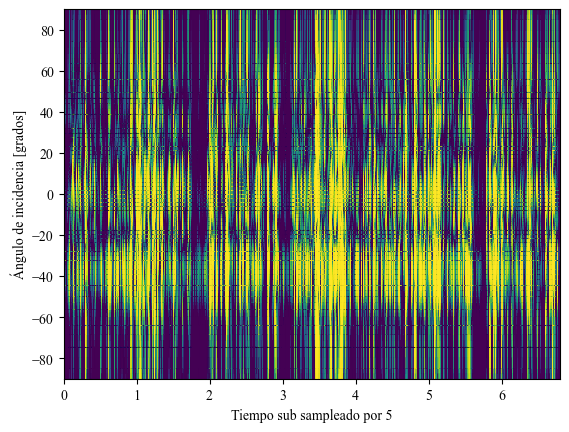

In [45]:
plt.pcolormesh(t, fi, R, shading='gouraud', norm = 'log', vmin = 5e3, vmax = 150e3)
plt.ylabel('Ángulo de incidencia [grados]')
plt.xlabel('Tiempo sub sampleado por 5')
plt.show()

Observamos en el espectrograma que tenemos una fuerte presencia de dos señales en $0\degree$ y $-40\degree$. También se pueden visualizar los ecos, que aparecen en todas las direcciones pero con menor intensidad que en los ángulos comentados. 

Se sub samplea por 5 el tiempo porque el gráfico explota.

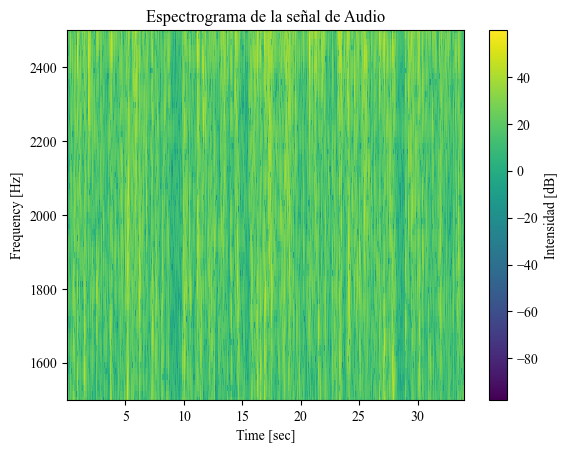

In [15]:
# Create a spectrogram
frequencies, times, Sxx = signal.spectrogram(arr[0, :], fs=fs, nfft=1024, )

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx))  # Convert to dB scale
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensidad [dB]')
plt.title('Espectrograma de la señal de Audio')
plt.ylim(1500, 2500)
plt.show()

En el espectrograma realizado a la señal de audio, notamos los 3 silencios que también se ven reflejados en el espectrograma de potencia espacial. Evidentemente, el espectrograma último mostrado no provee información sobre la ubicación de las fuentes de sonido.

# 2) Beamformer óptimo SMI.

Para realizar SMI, debemos estimar la matriz $R_{i+n}$, nosotros consideramos que nuestra interferencia es la radio por lo que se buscó un intervalo temporal donde no este presente la voz de la persona pero si la radio. 

In [9]:
display(ipd.Audio(arr[0,int(fs*25.8):int(fs*26.6)], rate=fs))
i_plus_noise = arr[:,int(fs*25.8):int(fs*26.6)]

In [10]:
Fc = 2e3
aux = arr[:,int(fs*25.8):int(fs*26.6)]
N = aux.shape[1]
y = np.zeros((9, N), dtype=np.complex128)
window = signal.windows.chebwin(9, at=30)
window = signal.windows.boxcar(9)

for i in range(9):
    y[i, :] = signal.sosfilt(sos_lp, window[i] * np.real(aux[i, :N] * np.exp(2j*np.pi*Fc/fs*np.arange(N))) ) \
         + 1j*signal.sosfilt(sos_lp, window[i] * np.imag(aux[i, :N] * np.exp(2j*np.pi*Fc/fs*np.arange(N))) )

Nfft = 64
frqs = fft.fftshift(fft.fftfreq(Nfft, d = 1))
R = np.zeros((Nfft, N//5))
for j in range(N//5):
    R[:, j] = np.abs(fft.fftshift(fft.fft(y[:, j*5], n=Nfft)))**2

t = np.arange(N//5)/fs

c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\scipy\signal\windows\_windows.py:1543: UserWarning: This window is not suitable for spectral analysis for attenuation values lower than about 45dB because the equivalent noise bandwidth of a Chebyshev window does not grow monotonically with increasing sidelobe attenuation when the attenuation is smaller than about 45 dB.
  warnings.warn("This window is not suitable for spectral analysis "


In [11]:
fi = np.rad2deg(np.arcsin(17/8 * frqs))
fi = np.array([-90 if np.isnan(val) and idx < len(fi)//2 else 90 if np.isnan(val) else val for idx, val in enumerate(fi)])

C:\Users\sch_b\AppData\Local\Temp\ipykernel_9700\3037835780.py:1: RuntimeWarning: invalid value encountered in arcsin
  fi = np.rad2deg(np.arcsin(17/8 * frqs))


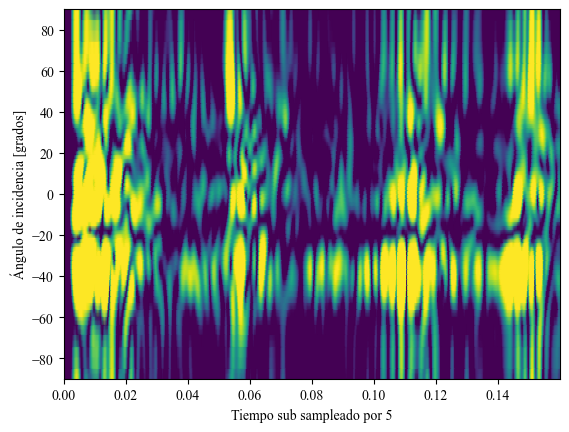

In [19]:
plt.close()
plt.pcolormesh(t, fi, R, shading='gouraud', norm = 'log', vmin=10000, vmax=200000)
plt.ylabel('Ángulo de incidencia [grados]')
plt.xlabel('Tiempo sub sampleado por 5')
plt.show()

Haciendo el espectrograma de frecuencia espacial de la señal $i+n$ del segmento que va de $25,8 s$ a $26,6 s$ notamos que evidentemente tenemos mayor presencia en la dirección de $-40$, aunque con bastantes ecos.  

In [12]:
# Para hacer Simple Matrix Inversion
# x: matrix de MxN. M: Cantidad de sensores. N: Cantidad de Muestras
def corr_matrix_estimator(x):
    R_i_plus_n_hat = np.zeros((x.shape[0], x.shape[0]), dtype=np.complex128)
    for j in range(x.shape[1]):
        R_i_plus_n_hat += np.outer(x[..., j], np.conjugate(x[..., j]))/x.shape[1]
    return R_i_plus_n_hat

In [18]:
M = 9
Fc = 2e3
N = i_plus_noise.shape[1] #// 100

s = np.zeros((M, i_plus_noise.shape[1]), dtype=np.float32)
n = np.arange(i_plus_noise.shape[1])

f0 = Fc
for i in range(s.shape[0]):
    s[i] = 5000*get_cos(n, f0, fs, i, 50, d = 8e-2) 

i_plus_noise_cos = i_plus_noise.copy() #+ s

base_band = np.zeros((M, N), dtype=np.complex128)
for i in range(9):
    base_band[i, :] = signal.sosfilt(sos_lp, np.real(i_plus_noise_cos[i, :] * np.exp(-2j*np.pi*Fc/fs*np.arange(N))) ) \
         + 1j*signal.sosfilt(sos_lp, np.imag(i_plus_noise_cos[i, :] * np.exp(-2j*np.pi*Fc/fs*np.arange(N))) )

R_i_plus_n_hat = corr_matrix_estimator(base_band) #+ 1*np.std(i_plus_noise_cos[0, :])*np.eye(9)
R_i_plus_n_hat_inv = linalg.inv(R_i_plus_n_hat)

C:\Users\sch_b\AppData\Local\Temp\ipykernel_9700\1751751345.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  s[i] = 5000*get_cos(n, f0, fs, i, 50, d = 8e-2)


C:\Users\sch_b\AppData\Local\Temp\ipykernel_9700\2786936106.py:12: RuntimeWarning: invalid value encountered in arcsin
  fi = np.rad2deg(np.arcsin(17/8*u))


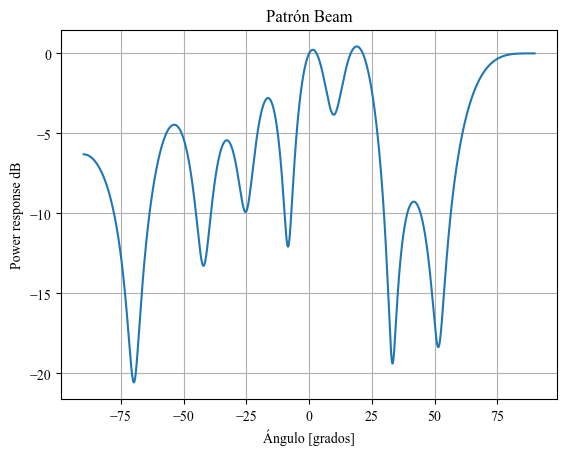

In [19]:
%matplotlib inline
M = 9
mm = np.arange(M)

v_fi_s = np.exp(-1j*2*np.pi*mm*np.sin(np.deg2rad(0))*8/17) / np.sqrt(M) # 0 grados
C = np.matmul(R_i_plus_n_hat_inv, v_fi_s) \
/ np.dot(np.conjugate(v_fi_s), np.matmul(R_i_plus_n_hat_inv, v_fi_s)) 
Y = np.abs(fft.fftshift(fft.fft(np.conjugate(C) / np.sqrt(M), n = 800000)))**2
u = fft.fftshift(fft.fftfreq(len(Y)))

plt.close()
fi = np.rad2deg(np.arcsin(17/8*u))
plt.figure()
plt.plot(fi, 10*np.log10(Y))
plt.title('Patrón Beam')
plt.xlabel('Ángulo [grados]')
plt.ylabel('Power response dB')
plt.grid()
plt.show()

Notamos que para $-40\degree$ atenúa -14/13dB. Asi mismo, hay otras direcciones que fueron atenuadas. Es importante entender que la hipótesis de que las interferencias son incorrelacionadas no es más válida, dado que los ecos son justamente interferencias correlacionadas y esto llega a que no se tenga el beamformer óptimo global. También observamos que tenemos ganancia unitaria en la dirección deseada, que es $0\degree$, ya que es donde suponemos que se encuntra la fuente de voz humana.

Se comenta que el hecho de que las interferencias sean correlacionadas efectivamente puede ser un problema, para la búsqueda del beamformer óptimo. No se muestra el código y resultados para no sobre cargar pero se inyectaron dos senos que provenian de disintas direcciones pero que tenian la misma frecuencia temporal, esto provocó que el beamformer no ponga los ceros exactamente en las direcciones esperadas, por lo que se debe tener sumo cuidado. 

C:\Users\sch_b\AppData\Local\Temp\ipykernel_9700\461857496.py:16: RuntimeWarning: invalid value encountered in arcsin
  fi = np.rad2deg(np.arcsin(17/8*u))


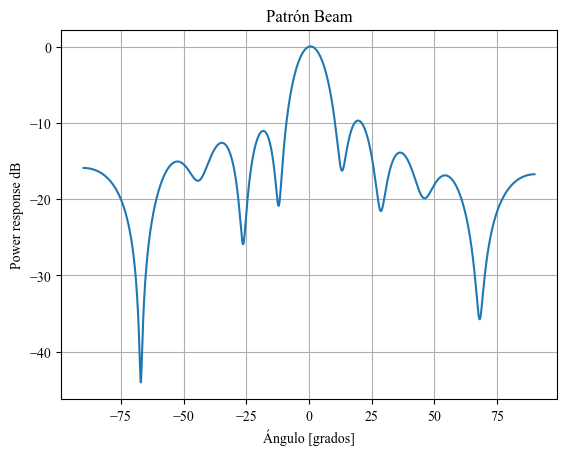

In [21]:
R_i_plus_n_hat = corr_matrix_estimator(base_band) + 10*np.std(i_plus_noise_cos[0, :])*np.eye(9)
R_i_plus_n_hat_inv = linalg.inv(R_i_plus_n_hat)


%matplotlib inline
M = 9
mm = np.arange(M)

v_fi_s = np.exp(-1j*2*np.pi*mm*np.sin(np.deg2rad(0))*8/17) / np.sqrt(M) # 0 grados
C = np.matmul(R_i_plus_n_hat_inv, v_fi_s) \
/ np.dot(np.conjugate(v_fi_s), np.matmul(R_i_plus_n_hat_inv, v_fi_s)) 
Y = np.abs(fft.fftshift(fft.fft(np.conjugate(C) / np.sqrt(M), n = 800000)))**2
u = fft.fftshift(fft.fftfreq(len(Y)))

plt.close()
fi = np.rad2deg(np.arcsin(17/8*u))
plt.figure()
plt.plot(fi, 10*np.log10(Y))
plt.title('Patrón Beam')
plt.xlabel('Ángulo [grados]')
plt.ylabel('Power response dB')
plt.grid()
plt.show()

El anterior gráfico es pseudo anecdótico, dado que se uso la técnica *diagonal loading*, que es básicamente inyectar ruido blanco, es decir, sumar una matriz de correlación $R_n$, con elementos no nulos en la diagonal y nulos afuera de la diagonal. De esta forma se logra una regularización que logra un patrón mas regular, aunque no se estimó el valor a usar de la potencia del ruido a inyectar. 

# 3) Beamformer FFT

Se comienza comentando que se hizo uso de la ventana de Hann en lugar de la vetana de Hamming, dado que la ventana de Hann con overlap de $50\%$, logra una reconstrucción perfecta. Seguro la de Hamming también se usa pero no se vió claro. 

Dado que consideramos que la voz va de $100\text{Hz}$ a $7\text{kHz}$ y que para tener narrowband, requerimos un BW de $5%$ respecto a $F_c$, por lo tanto si consideramos la mayor densidad de potencia de audio estará en los $200\text{Hz}$, dado que se usará una FFT con ventana de Hann, el ancho de banda de cada bin estará determinado por el largo de la ventana, por lo que 

$$
W(f) = \frac{\sin{(\pi L f)}}{2\pi L f (1-L^2f^2)}
$$

$$
\Delta f = \frac{4}{N-1} \cdot f_s = \frac{4}{N-1} \cdot 16000 = 0.05\cdot800 = 10\text{Hz}
$$

$$
N = f_s \cdot T_{win} = \frac{4}{\Delta f}\cdot f_s
$$

$$
T_{win} = \frac{4}{\Delta f}
$$

Para $\Delta f = 40\text{Hz}$, tenemos que $N = 1601$, que es $T_{win} = 100\text{ms}$.

Se aclará que se usará el arreglo de $d =16\text{cm}$, si bien hay frecuencias temporales altas que no cumplen Nyquist, para las frecuencias temporales bajas se tiene una mucho mayor resolución espacial.

# Matched filter en función de la frecuencia temporal

C:\Users\sch_b\AppData\Local\Temp\ipykernel_25220\1105671983.py:17: RuntimeWarning: invalid value encountered in arcsin
  fi = np.rad2deg(np.arcsin((c/Fc_)/d*u))


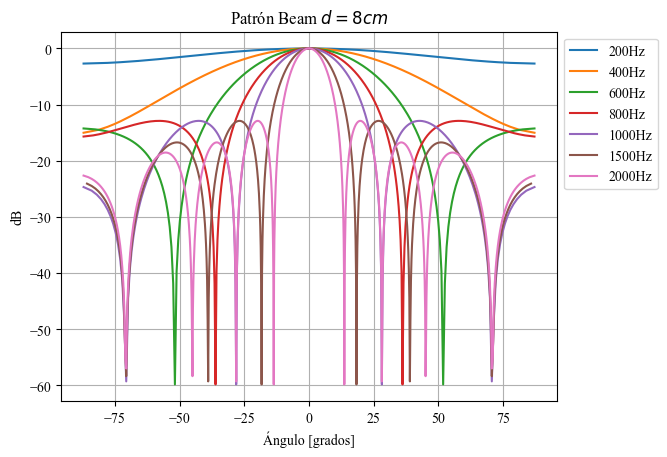

In [39]:
%matplotlib inline
M = 9
c = 340
angle = 0
d = 8e-2
Fc = 2000
Cmf = np.exp(-1j*2*np.pi*Fc*np.arange(M)*d*np.sin(np.deg2rad(angle))/c)/np.sqrt(M)

Y = np.abs(fft.fftshift(fft.fft(Cmf / np.sqrt(M), n = 1000)))
u = fft.fftshift(fft.fftfreq(len(Y)))

plt.close()
plt.figure()

Fc_arr = [200, 400, 600, 800, 1000, 1500, 2000]
for Fc_ in Fc_arr: 
    fi = np.rad2deg(np.arcsin((c/Fc_)/d*u))
    plt.plot(fi, 20*np.log10(Y), label = f'{Fc_}Hz')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Patrón Beam $d = 8cm$')
plt.xlabel('Ángulo [grados]')
plt.ylabel('dB')
plt.grid()
plt.show()

C:\Users\sch_b\AppData\Local\Temp\ipykernel_25220\1188179925.py:17: RuntimeWarning: invalid value encountered in arcsin
  fi = np.rad2deg(np.arcsin((c/Fc_)/d*u))


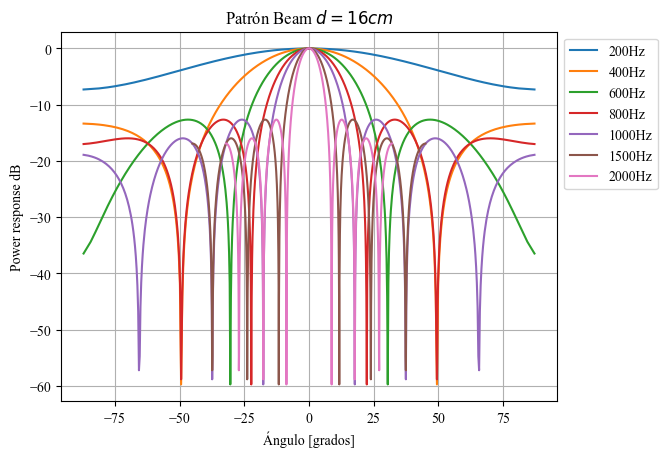

In [44]:
M = 7
c = 340
angle = 0
d = 16e-2
Fc = 2000
Cmf = np.exp(-1j*2*np.pi*Fc*np.arange(M)*d*np.sin(np.deg2rad(angle))/c)/np.sqrt(M)

Y = np.abs(fft.fftshift(fft.fft(Cmf / np.sqrt(M), n = 1000)))
u = fft.fftshift(fft.fftfreq(len(Y)))

plt.close()
plt.figure()

Fc_arr = [200, 400, 600, 800, 1000, 1500, 2000]

for Fc_ in Fc_arr: 
    fi = np.rad2deg(np.arcsin((c/Fc_)/d*u))
    plt.plot(fi, 20*np.log10(Y), label = f'{Fc_}Hz')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Patrón Beam $d = 16cm$')
plt.xlabel('Ángulo [grados]')
plt.ylabel('Power response dB')
plt.grid()
plt.show()

Como se observa en los dos gráficos anteriores, se tiene mejor resolución para $d = 16 cm $

In [ ]:
""" def beamformer(x_in, c, N = 1601):
    K = len(x_in)//(N//2 + 1)
    K = 18
    freqs = fft.fftfreq(N)
    C = fft.fft(x = np.r_[c, np.zeros(N-1)], n = N)
    y = np.zeros(len(x_in), dtype=np.complex128)
    for k in range(K):
        x = x_in[k*(N//2) : k*(N//2) + N].copy()
        X = fft.fft(x = x*signal.windows.hann(N), n = N)
        Y = C * X
        y[k*(N//2) : k*(N//2) + N] += fft.ifft(Y)
    return y

x = np.sin(2*np.pi*100/fs*np.arange(int(fs*1)))

y = beamformer(x, 2)

plt.close()
plt.figure()
plt.plot(x)
plt.plot(y)
plt.show() """

Tenemos que un beamformer es:
$$
y(n) = \bold{C}^H  \bold{X}(n)
$$
donde 
$$
\bold{C} = [c_1, c_2, c_3, ..., c_M]^T
$$
$$
\bold{X} = [x_1(n), x_2(n) x_3(n), ..., x_M(n)]^T
$$

Ahora bien, la operación del beamformer, se puede pensar se la siguiente manera:

$$
y(n) = (c_1 * x_1)(n) + (c_2 * x_2)(n) + (c_3 * x_3)(n) + ... + (c_M * x_M)(n)
$$
Es decir, podemos verlo como convoluciones, en particular, los coeficientes $c_{\cdot}$, son **respuestas impulsivas** de filtros. Resulta trivial notar que para que $(c_1 * x_1)(n) = c_1(0) x_1(n)$, se tiene que $c_1(n)$ es una delta. 

Analizar esto de esta forma permite hacer uso de la FFT para computar las convoluciones. Siempre teniendo en cuenta que hay que padear con ceros las señales para que la convolución circular sea *como si* se hubiese hecho una convolución lineal. Resulta trivial notar que hay que padear con $M + 1 - 1$ ceros, y dado que la FFT de una delta es una constante, tenemos el problema resuelto. 
Dado que resulta de interés poder aplicar SMI a cada banda, dado que las técnicas de beamforming trabajan en narrowband, es de interés poder controlar cada bin, o sea, tener coeficientes con rta impulsiva como una delta no permite hacer un estudio por bandas, dado que les otorga misma ganancia a todas las bandas. Por lo tanto, tener coeficientes que son función del bin, es como tener una respuesta impulsiva que no es una delta, si no que tiene una duración, es decir, el beamformer dado por $y(n) = \bold{C}^H  \bold{X}(n)$ no depende más del último snapshot, si no que tiene memoria. Esto simplemente fue una forma de distinta de ver la FFT, porque Frost en 1972 plantea un beamformer con FIR. 


$$
c_1 = c_1(f)  
$$

$$
C_1(k) = \sum_{n=0}^{N-1} c_1(n, k) e^{j 2\pi/N \cdot k  \cdot n} = c_1(k) 
$$
Porque $c_1(n, k)$ se anula para $n>0$
$$
c_1(n, k) = c_1(k)\cdot \delta(n)
$$

Para el caso en que se usa la misma ventana beam para todas las frecuencias $F_c$, $c_1(k) = c_1, \forall k$

In [54]:
# x_in.shape: (M, Ntotal)
# c = (M, N) Donde N sería la cantidad de bins. Matriz de coeficientes. Cada columna seria los C para esa narrowband
# N : Size de la ventana. Debe ser impar
# Se usa hann con overlap 50%

def fft_beamformer(x_in, c, N = 1601):
    K = x_in.shape[1]//(N//2 + 1) - 1 
    y = np.zeros(x_in.shape[1], dtype=np.complex128)
    Y = np.zeros(N, dtype=np.complex128)
    for k in range(K):
        x = x_in[:, k*(N//2) : k*(N//2) + N].copy()
        for i in range(x.shape[0]):
            x[i, :] *= signal.windows.hann(N)
        X = fft.fft(x = x, n = N, axis = 1)
        for j in range(X.shape[1]):
            Y[j] = np.dot(X[:, j], np.conjugate(c[:, j]))
        y[k*(N//2) : k*(N//2) + N] += fft.ifft(Y)
    return y

# Prueba de filtrado beamformer sin FFT
Inyecto un seno de 2kHz a $45 \degree$ y veo su respuesta, uso un beamformer steered a $0\degree$.

In [55]:
M = 9
fs = 16000
f0 = 2e3
T_window = 1000e-3
n = np.arange(0, int(fs*T_window))

C = np.ones(M, dtype=np.complex128) / np.sqrt(M)
s = np.zeros((M, len(n)), dtype=np.complex128)

for i in range(s.shape[0]):
    s[i] = get_cos(n, f0, fs, i, 0, d = 8e-2) #+  get_cos(n, 400, fs, i, -60, d = 8e-2)#+ get_cos(n, f0, fs, i, 10.3)

y = np.zeros(s.shape[1])
y_fft = np.zeros(s.shape[1])
N = 1601
c = np.zeros((M, N), dtype=np.complex128)
for j in range(N):
    c[:, j] = C

y_fft = fft_beamformer(s, c, N = 1601) / np.sqrt(M)

for j in range(s.shape[1]):
    y[j] = np.dot(np.conjugate(C), s[:, j])/np.sqrt(M)

C:\Users\sch_b\AppData\Local\Temp\ipykernel_25220\3246875357.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  y[j] = np.dot(np.conjugate(C), s[:, j])/np.sqrt(M)


In [159]:
pow(base=10, exp=-20/20)

0.1

c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


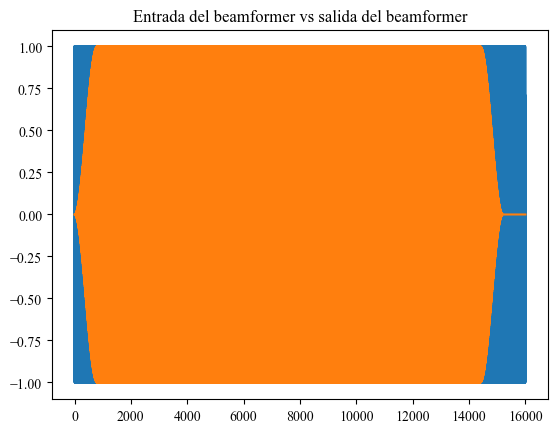

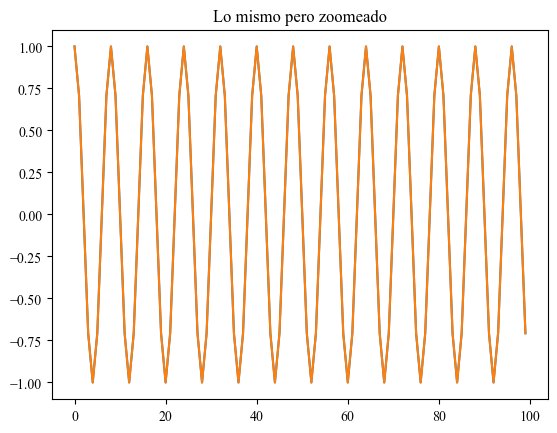

In [59]:
plt.close()
plt.figure()
plt.title('Entrada del beamformer vs salida del beamformer')
plt.plot(y)
plt.plot(y_fft)

plt.show()

plt.close()
plt.figure()
plt.title('Lo mismo pero zoomeado')
plt.plot(y[4000:4100])
plt.plot(y_fft[4000:4100])

plt.show()

Notamos que el FFT beamfomer, funciona perfecto, tiene la propiedad de **reconstrucción perfecta**. El hecho de que al principio tenga ese transitorio, es porque por la ventana de hann siempre va a arrancar y terminar así. Al final hay la señal se anula porque no llega a agarra justo una ventana del tamaño mínimo requerido. Bugs que se solucionan facil pero que no valen la pena aca.

# Filtro audio con beamformer FFT. Con misma ventana para todos los bines

Al audio original, le inyecto una senoide de $500\text{Hz}$, exactamente en un 0 de la ventana rectangular, se puede escuchar que se atenua completamente

In [60]:
fs, arr16 = wavfile.read(filename='mtms-arrC1A.wav')
arr16 = np.swapaxes(arr16, 0, 1)
arr16.shape

(15, 543489)

In [61]:
arr16 = np.take(arr16, [0, 1, 3, 7, 11, 13, 14], axis = 0)

In [62]:
arr16.shape

(7, 543489)

In [63]:
M = 7
C = np.ones(M, dtype=np.complex128) / np.sqrt(M)
c = np.zeros((M, N), dtype=np.complex128)
N = 1601
tst = arr16[:, :int(fs*5)].astype(np.float32).copy()

s = np.zeros((M, tst.shape[1]), dtype=np.float32)
n = np.arange(tst.shape[1])

f0 = 500
for i in range(s.shape[0]):
    s[i] = 5000*get_cos(n, f0, fs, i, -37, d = 16e-2) 

tst = s + tst
for j in range(N):
    c[:, j] = C

y = np.zeros(tst.shape[1])
y = fft_beamformer(tst, c, N = 1601) / np.sqrt(M)

C:\Users\sch_b\AppData\Local\Temp\ipykernel_25220\2712034964.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  s[i] = 5000*get_cos(n, f0, fs, i, -37, d = 16e-2)


In [65]:
display(ipd.Audio(tst[0, :], rate=fs))

In [66]:
display(ipd.Audio(y, rate=fs))

c:\Users\sch_b\OneDrive\Documentos\PASA\.PASA\Lib\site-packages\IPython\lib\display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


# Filtro óptimo por bandas

Llevo a banda base cada banda, para hacer SMI sobre cada una.

In [67]:
M = 7
s = np.zeros((M, arr16[:,int(fs*25.8):int(fs*26.6)].shape[1]), dtype=np.float32)
n = np.arange(arr16[:,int(fs*25.8):int(fs*26.6)].shape[1])

f0 = 500
for i in range(s.shape[0]):
    s[i] = 10000*get_cos(n, f0, fs, i, 50, d = 16e-2) 

i_plus_noise = arr16[:,int(fs*25.8):int(fs*26.6)] + s
display(ipd.Audio(i_plus_noise, rate=fs))

C:\Users\sch_b\AppData\Local\Temp\ipykernel_25220\1487343831.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  s[i] = 10000*get_cos(n, f0, fs, i, 50, d = 16e-2)


In [68]:
M = 7
mm = np.arange(M)
c = 340
d = 16e-2
Nfft = N*4
N = i_plus_noise.shape[1]
i_plus_noise_aux = i_plus_noise.copy()
y_base_band = np.zeros((M, N), dtype=np.complex128)

freqs = fft.fftfreq(1601, d = 1/fs)
c_matrix = np.zeros((M, 1601), dtype=np.complex128)
for j, Fc in enumerate(freqs):
    for i in range(M):
        y_base_band[i, :] = signal.sosfilt(sos_lp, np.real(i_plus_noise_aux[i, :] * np.exp(-2j*np.pi*Fc/fs*np.arange(N))) ) \
            + 1j*signal.sosfilt(sos_lp, np.imag(i_plus_noise_aux[i, :] * np.exp(-2j*np.pi*Fc/fs*np.arange(N))) )
        
    R_i_plus_n_hat = corr_matrix_estimator(y_base_band) #+ np.std(i_plus_noise_aux[0, :])*np.eye(7)
    R_i_plus_n_hat_inv = linalg.inv(R_i_plus_n_hat)
    v_fi_s = np.exp(-1j*2*np.pi*Fc*mm*d*np.sin(np.deg2rad(0))/c) / np.sqrt(M) # 0 grados
    C = np.matmul(R_i_plus_n_hat_inv, v_fi_s) \
    / np.dot(np.conjugate(v_fi_s), np.matmul(R_i_plus_n_hat_inv, v_fi_s)) 
    c_matrix[:, j] = C


C:\Users\sch_b\AppData\Local\Temp\ipykernel_25220\1203755724.py:12: RuntimeWarning: invalid value encountered in arcsin
  fi = np.rad2deg(np.arcsin(c/(freqs[idx]*d)*u))


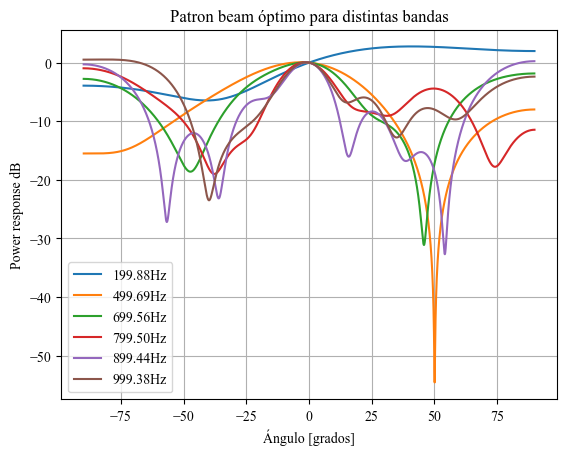

In [70]:
plt.close()
plt.figure()
M = 7
look_freqs = [200, 500, 700, 800, 900, 1000]
idxs = [np.abs(freqs - freq).argmin() for freq in look_freqs]
d = 16e-2
c = 340

for idx in idxs:
    Y = np.abs(fft.fftshift(fft.fft(np.conjugate(c_matrix[:, idx]) / np.sqrt(M), n = 800000)))
    u = fft.fftshift(fft.fftfreq(len(Y)))
    fi = np.rad2deg(np.arcsin(c/(freqs[idx]*d)*u))
    plt.plot(fi, 20*np.log10(Y), label = f'{freqs[idx]:.{2}f}Hz')

plt.title('Patron beam óptimo para distintas bandas')
plt.xlabel('Ángulo [grados]')
plt.ylabel('Power response dB')
plt.legend()
plt.grid()
plt.show()

Resulta muy interesante el gráfico anterior. Nosotros inyectamos una señal en 50 grados. Evidentemente esta señal sintética, no tiene ecos, y tiene bastante potencia. Notamos como para las bandas cercanas a los $500Hz$ puso el cero y perceptualmente luego no se la escucha absolutamente nada. También vemos que para los $-40\degree$ logra atenuar aunque para bandas de baja frecuencia le cuesta bastante dado su baja resolución espacial.

Aplico el beamformer con fft al audio

In [71]:
audio = arr16[:,:int(fs*10)].copy()
s = np.zeros((M, audio.shape[1]), dtype=np.float32)
n = np.arange(audio.shape[1])

f0 = 500
for i in range(s.shape[0]):
    s[i] = 10000*get_cos(n, f0, fs, i, 50, d = 16e-2) 

mixed = audio + s
display(ipd.Audio(audio, rate=fs))

C:\Users\sch_b\AppData\Local\Temp\ipykernel_25220\2608303241.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  s[i] = 10000*get_cos(n, f0, fs, i, 50, d = 16e-2)


In [72]:
M = 7
y = fft_beamformer(mixed, c_matrix, N = 1601) / np.sqrt(M)

In [73]:
display(ipd.Audio(y, rate=fs))

# Conclusiones

Si tenemos un audio con una potencia normal, estándar, resulta trivial saber que se necesita más de 30dB te atenuación para que perceptualmente se complicado escuchar, es un problema el gran rango dinámico del oido. Por lo que si bien los resultados no son muy buenos, el uso de otras técnicas de beamoforming u otras topologías de arreglos pueden ser usadas. 